### To be run in colab

In [1]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [3]:
!pip install --quiet git+https://github.com/theislab/scgen.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import the metric -- scib

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.6 MB/s eta 0:00:00


In [6]:
!pip install --quiet louvain
import louvain

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-6-bf0d4c071418>:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be

### Import the necessary library

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [2]:
import os
import tempfile

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

/opt/anaconda3/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### read the data

In [5]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata = anndata.read_h5ad("./Lung_atlas_public.h5ad")
adata

/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/dataset' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/location' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/location' was written without encoding metadata.
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.1

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [7]:
celltype_markers = pd.read_csv("./celltype_lung_atlas.csv", index_col=0)

adata.obs.index = adata.obs.index.astype("str")
adata.var.index = adata.var.index.astype("str")
adata.var_names_make_unique()
adata.obs_names_make_unique()

adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [11]:
print(celltype_markers.index)

Index(['MS4A1', 'BANK1', 'LINC00926', 'CD79A', 'BLK', 'CD79B', 'VPREB3',
       'SP140', 'CD22', 'ADAM28', 'KRT15', 'S100A2', 'KRT17', 'KRT5', 'KRT19',
       'PERP', 'CLDN1', 'FHL2', 'DST', 'ITGA2', 'RSPH1', 'CAPS', 'FAM92B',
       'CDHR3', 'CCDC170', 'SNTN', 'C20orf85', 'ZMYND10', 'DNAH6', 'FANK1',
       'HLA-DPB1', 'FCGR2B', 'HLA-DMB', 'CLEC10A', 'CSF2RA', 'MS4A6A',
       'HLA-DQA1', 'RGS1', 'GPR183', 'FPR3', 'FBLN1', 'ADH1B', 'DCN', 'LUM',
       'C1S', 'C1R', 'SLIT2', 'C3', 'CFD', 'ABLIM1', 'CCL21', 'MMRN1', 'PROX1',
       'PPFIBP1', 'TFF3', 'TBX1', 'PKHD1L1', 'IGFBP7', 'TFPI', 'TIMP3', 'ACP5',
       'C1QA', 'C1QB', 'VSIG4', 'MARCO', 'OLR1', 'APOC1', 'SLCO2B1', 'GPD1',
       'ITGAX', 'GNLY', 'CD7', 'CTSW', 'CCL5', 'CD2', 'ZFP36L2', 'CXCR4',
       'LGALS1', 'CEBPB', 'S100A6', 'H2AFZ', 'CDK1', 'UBE2C', 'ANLN', 'BIRC5',
       'NUSAP1', 'STMN1', 'TPX2', 'TYMS', 'KPNA2', '}'],
      dtype='object', name='Gene')


In [15]:
print(adata.var_names)

Index(['A1BG-AS1', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AADAC',
       'AADAT', 'AAED1', 'AAGAB',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=15148)


In [14]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [18]:
# Ensure that only the shared gene names between adata.var_names and celltype_markers.index are kept.
bdata = adata[:, adata.var_names.isin(celltype_markers.index)].copy()

In [21]:
print(bdata.var_names)

Index(['ACP5', 'ADAM28', 'ADH1B', 'APOC1', 'BIRC5', 'C1QA', 'C1QB', 'C1R',
       'C1S', 'C20orf85', 'C3', 'CAPS', 'CCDC170', 'CCL21', 'CCL5', 'CD2',
       'CD22', 'CD7', 'CD79A', 'CD79B', 'CDHR3', 'CFD', 'CLEC10A', 'CSF2RA',
       'CTSW', 'CXCR4', 'DCN', 'DNAH6', 'DST', 'FAM92B', 'FANK1', 'FBLN1',
       'FCGR2B', 'FHL2', 'FPR3', 'GNLY', 'GPR183', 'HLA-DMB', 'HLA-DPB1',
       'HLA-DQA1', 'IGFBP7', 'ITGAX', 'KPNA2', 'KRT15', 'KRT17', 'KRT19',
       'KRT5', 'LGALS1', 'LINC00926', 'LUM', 'MARCO', 'MMRN1', 'MS4A1',
       'MS4A6A', 'NUSAP1', 'OLR1', 'PPFIBP1', 'PROX1', 'RGS1', 'RSPH1',
       'S100A2', 'SLCO2B1', 'SNTN', 'SP140', 'STMN1', 'TFF3', 'TFPI', 'TIMP3',
       'TYMS', 'UBE2C', 'VSIG4', 'ZFP36L2', 'ZMYND10'],
      dtype='object', name='index')


## CellAssign

In [24]:
lib_size = adata.X.sum(1)
adata.obs["size_factors"] = lib_size / np.mean(lib_size)

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_8288/2900961381.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["size_factors"] = lib_size / np.mean(lib_size)


A size factor may be defined manually as scaled library size (total UMI count) and should not be placed on the log scale, as the model will do this manually. The library size should be computed before any gene subsetting (in this case, technically, a few notebook cells up).

In [27]:
scvi.external.CellAssign.setup_anndata(bdata, size_factor_key="size_factors")

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [29]:
model = CellAssign(bdata, celltype_markers)
model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 319/400:  80%|▊| 319/400 [10:33<02:40,  1.99s/it, v_num=1, train_loss_step
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 49.509. Signaling Trainer to stop.


In [31]:
predictions = model.predict()
predictions.head()

B cell    basal cell  ciliated cell  dendritic cell    fibroblast  \
0  0.000579  1.290146e-02   9.851335e-01    6.098349e-11  7.481798e-15   
1  0.003530  9.591760e-01   2.229116e-08    1.402618e-10  6.075468e-03   
2  0.027688  8.995036e-01   2.099932e-08    6.979832e-11  3.031053e-13   
3  0.006401  2.973131e-02   9.578877e-01    5.918711e-03  6.086128e-05   
4  0.000011  4.259390e-13   9.999664e-01    2.644437e-13  2.244865e-05   

   lymphatic vessel    macrophage  mature NK T cell  
0      5.040421e-06  4.528793e-20      1.380699e-03  
1      1.461963e-02  4.092108e-08      1.659922e-02  
2      2.592670e-04  4.889879e-09      7.254934e-02  
3      3.858850e-07  6.913811e-18      4.513768e-11  
4      9.421909e-22  7.784092e-20      3.442884e-15

/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


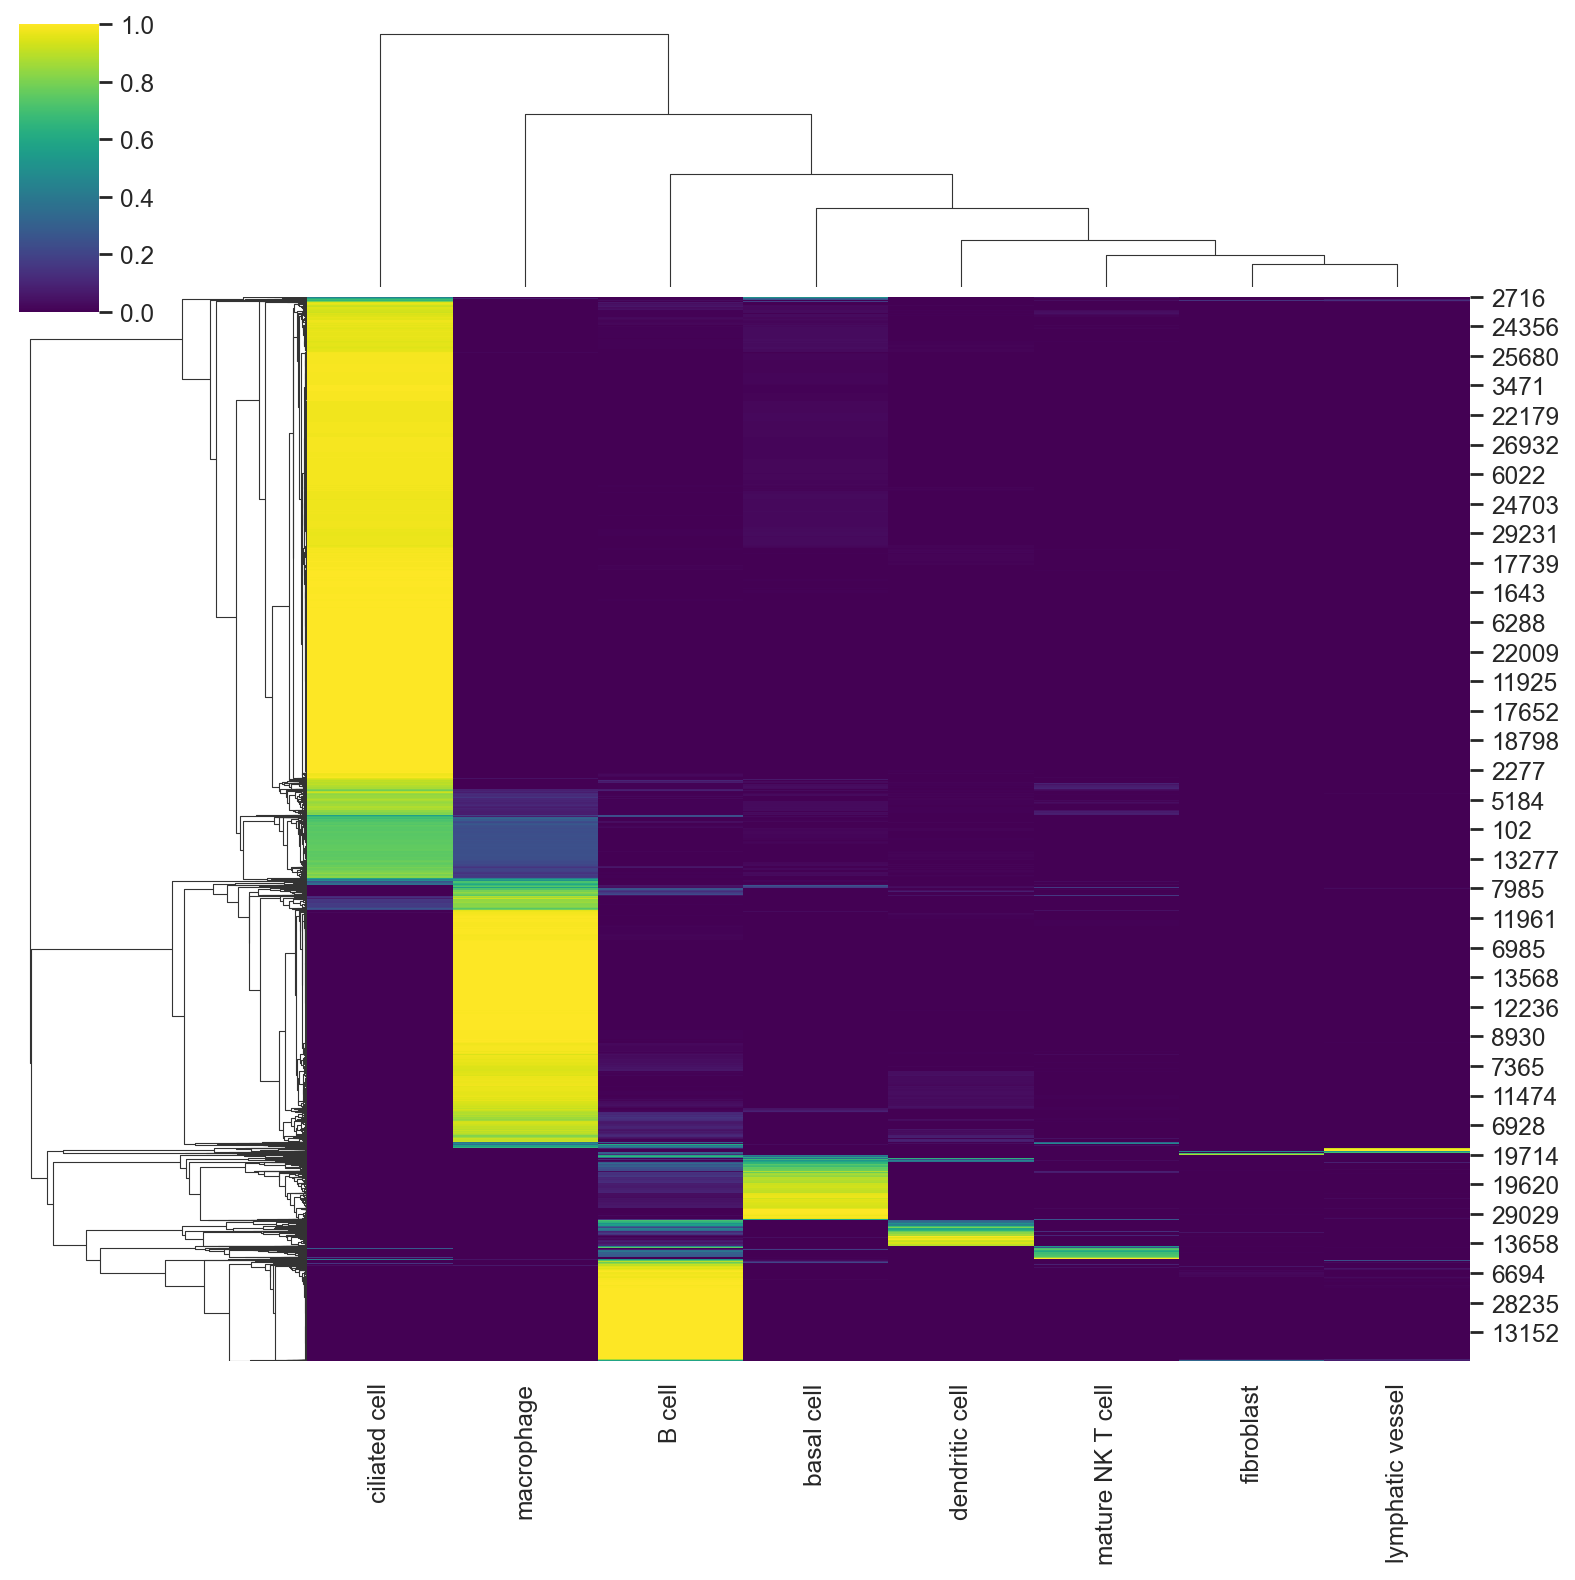

In [33]:
sns.clustermap(predictions, cmap="viridis")

In [34]:
bdata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values

In [35]:
# save the prediction results to csv file
import pandas as pd

cellassign_predictions = bdata.obs["cellassign_predictions"]

cellassign_predictions.to_csv("./lung_atlas_cellassign_predictions.csv", index=True)

In [16]:
# load the prediction results to adata
predict_labels = pd.read_csv("./lung_atlas_cellassign_predictions.csv")

adata.obs['predict_labels'] = predict_labels.iloc[:, 1].values

/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/ipykernel_17413/4220259075.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['predict_labels'] = predict_labels.iloc[:, 1].values


In [18]:
adata.obs['predict_labels'] = adata.obs['predict_labels'].astype('category')

In [20]:
embeddings_dict = {}

# scANVI

In [11]:
# scVI training -- no need to run every time
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 12/246:   4%| | 11/246 [02:26<54:45, 13.98s/it, v_num=1, train_loss_step=3

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# Save the VAE model to a file named 'model.pt'
save_path = "./model_scVI"
vae.save(save_path)

In [22]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File ./model_scVI/model.pt already downloaded                                                             


/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [23]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


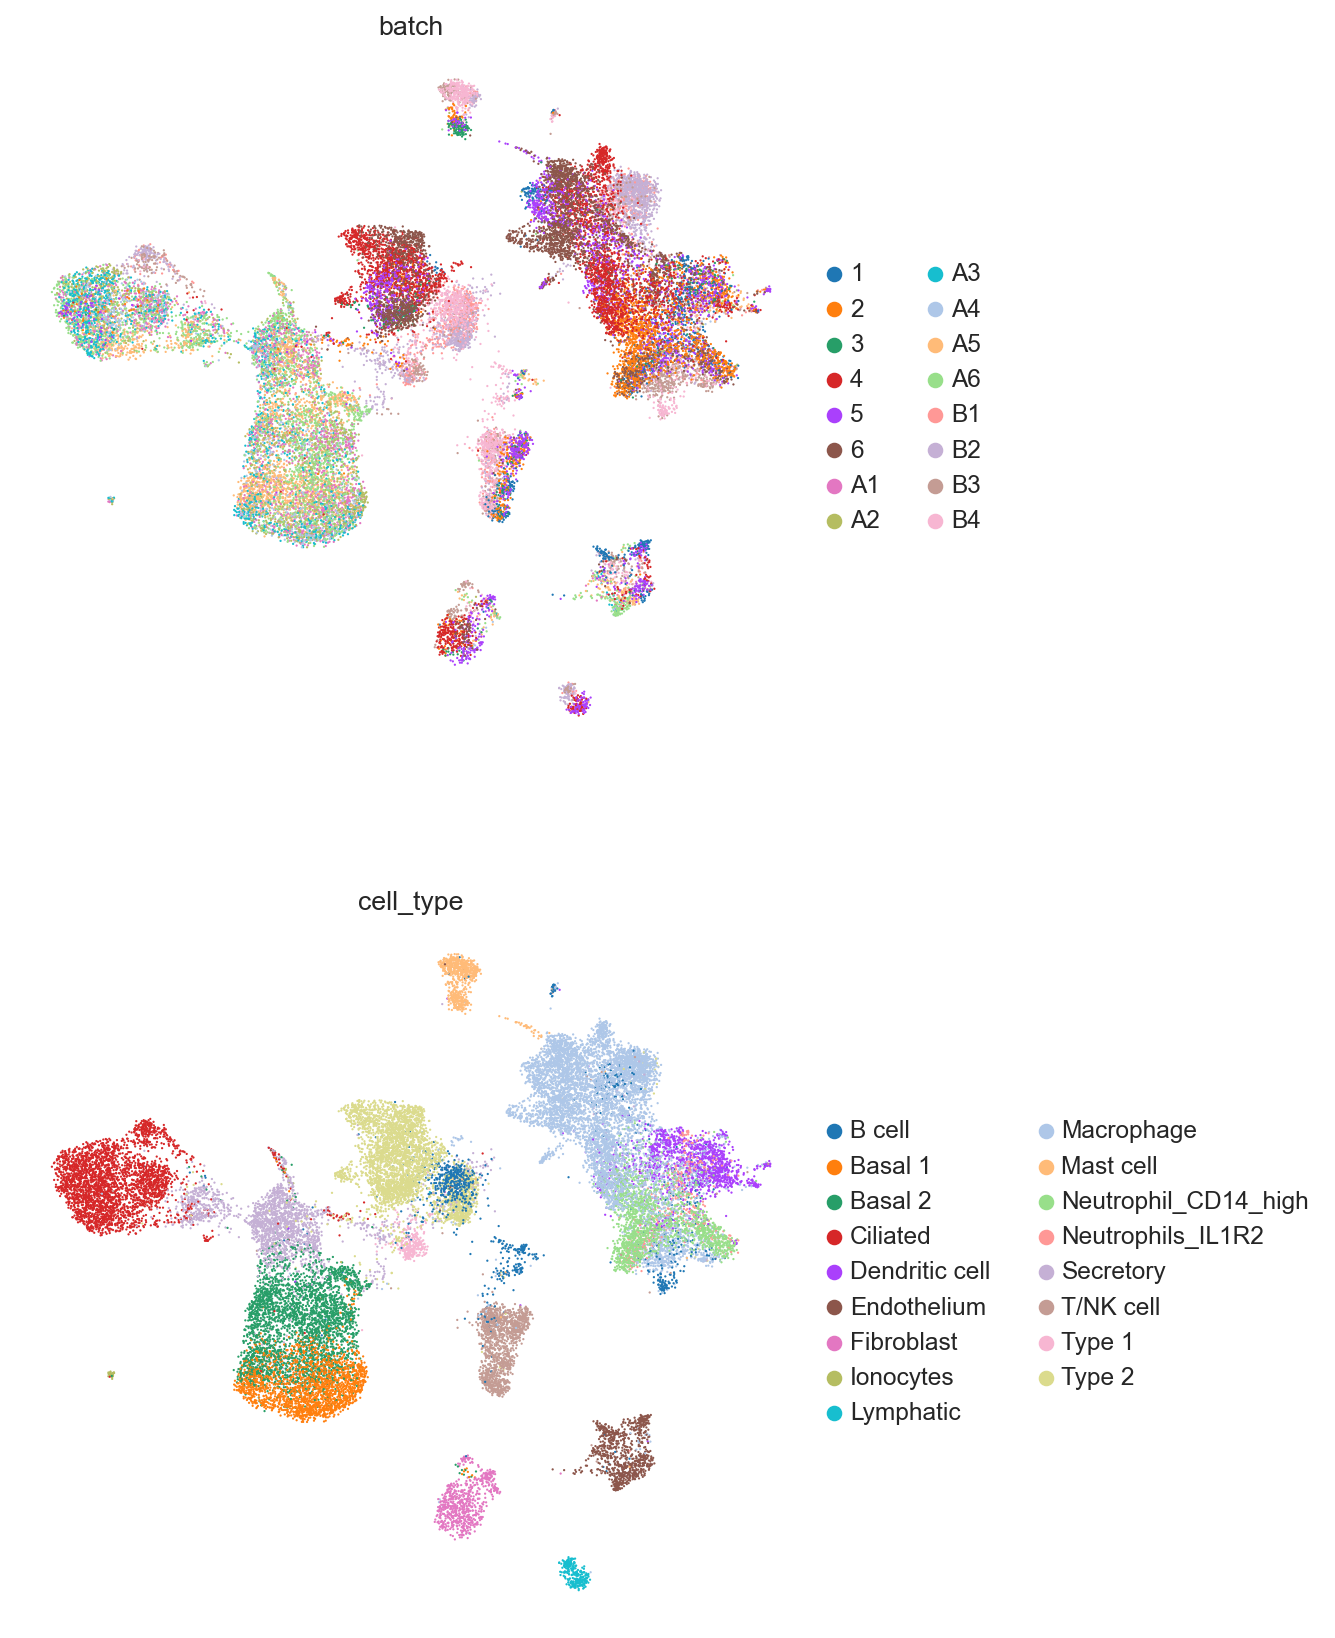

In [24]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [26]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="predict_labels",
    unlabeled_category="Unknown",
)

/opt/anaconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [27]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|█| 20/20 [01:46<00:00,  5.23s/it, v_num=1, train_loss_step=425

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:46<00:00,  5.34s/it, v_num=1, train_loss_step=425


In [28]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [29]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [30]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

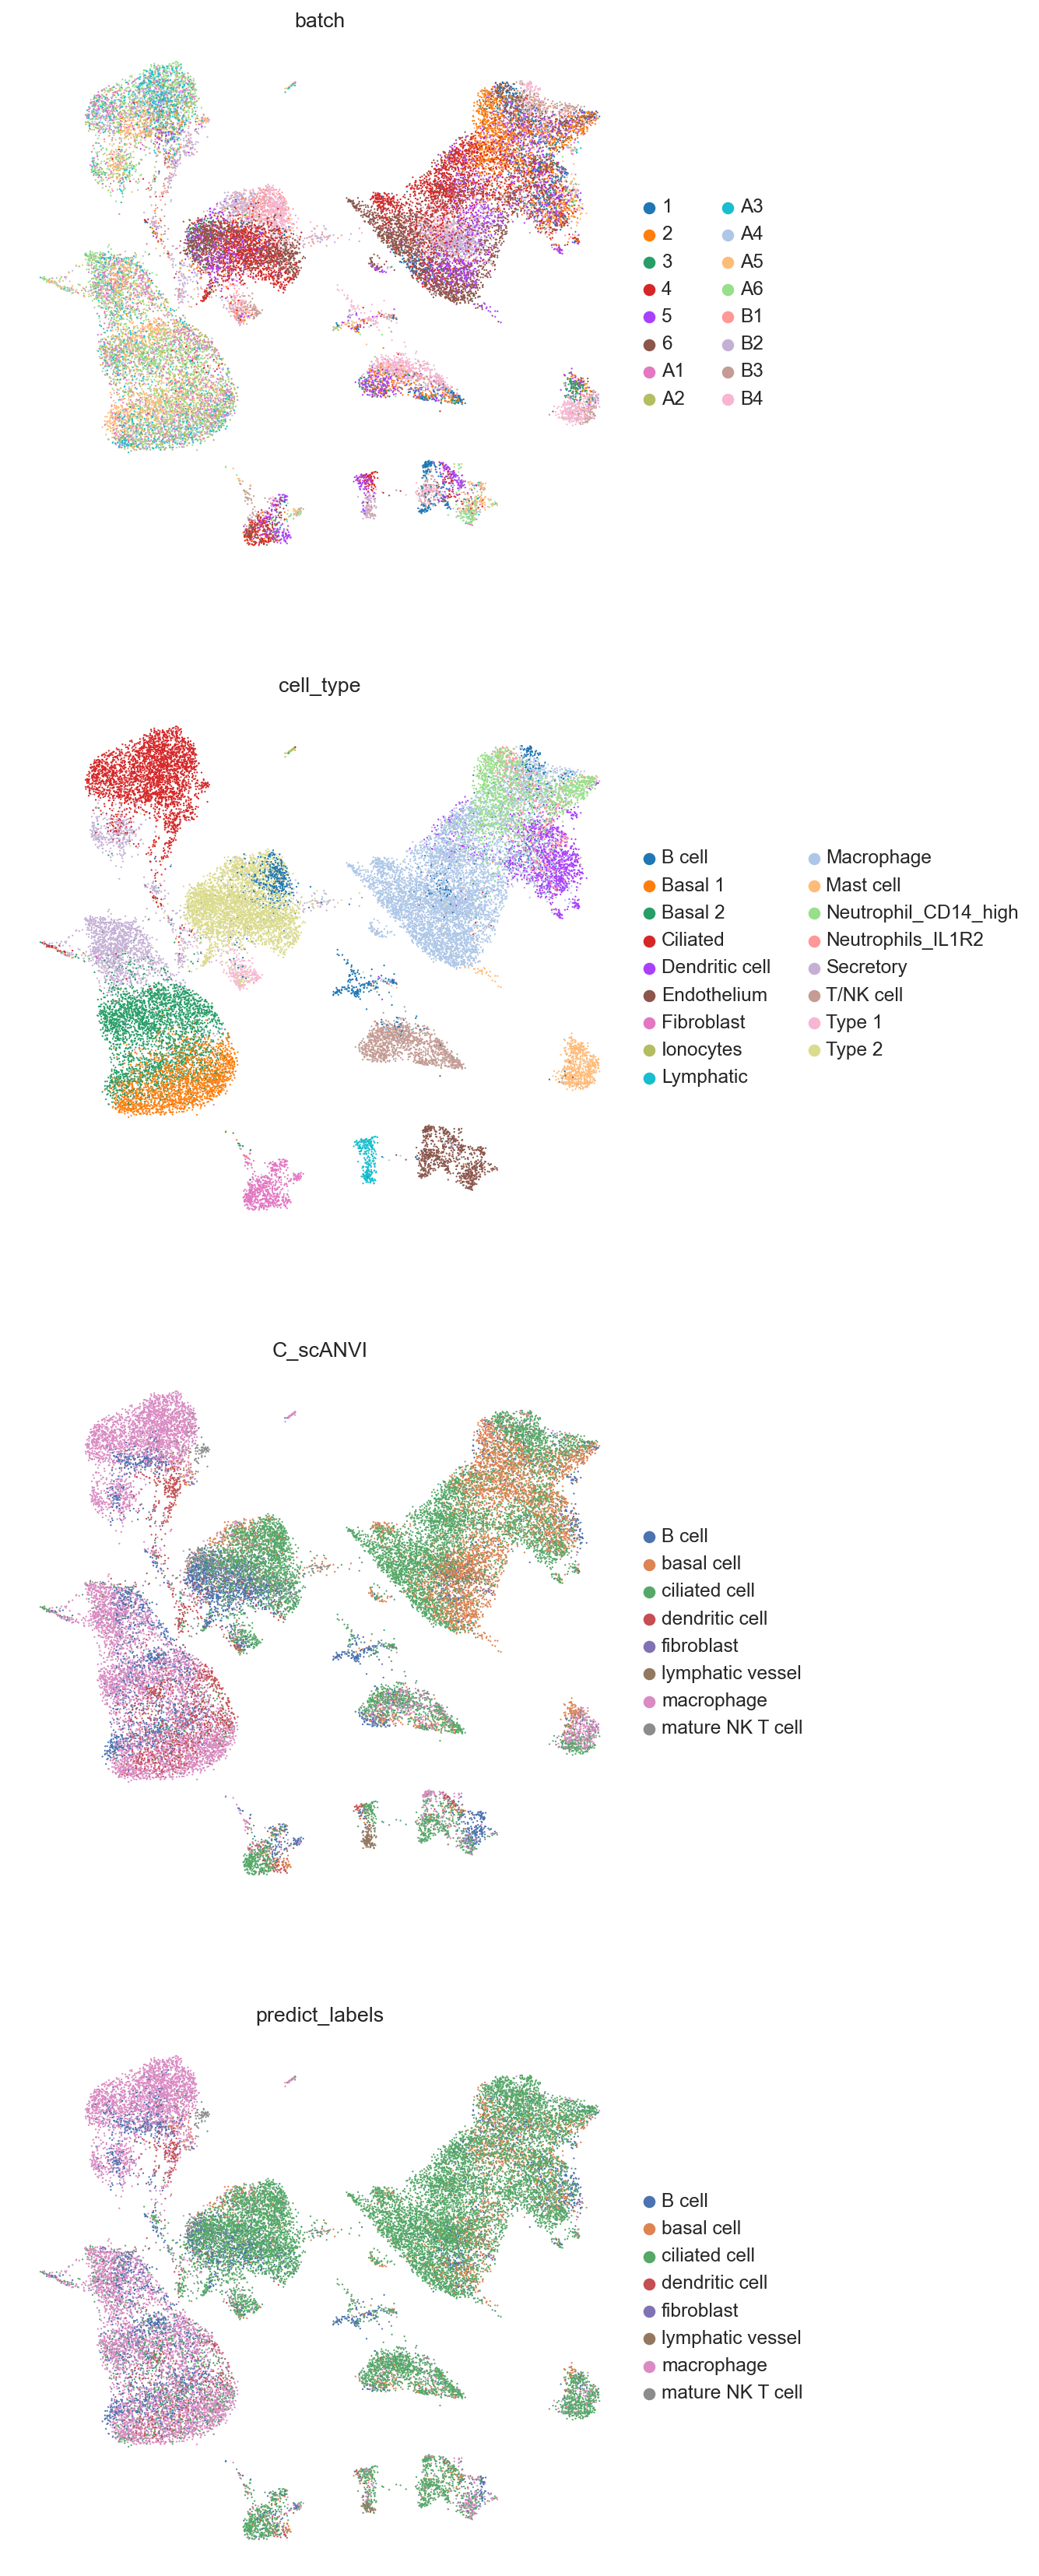

In [31]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI",  "predict_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [34]:
train = adata.copy()

### Preprocessing Data

In [36]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="predict_labels")

## Creating and Training the model¶

In [38]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 28/100:  28%|▎| 28/100 [05:25<13:55, 11.61s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1289.357. Signaling Trainer to stop.


## Batch-Removal

In [40]:
corrected_adata = model.batch_removal()
corrected_adata

/opt/anaconda3/lib/python3.12/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 29256 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'n_genes', 'n_counts', 'predict_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [41]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [43]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


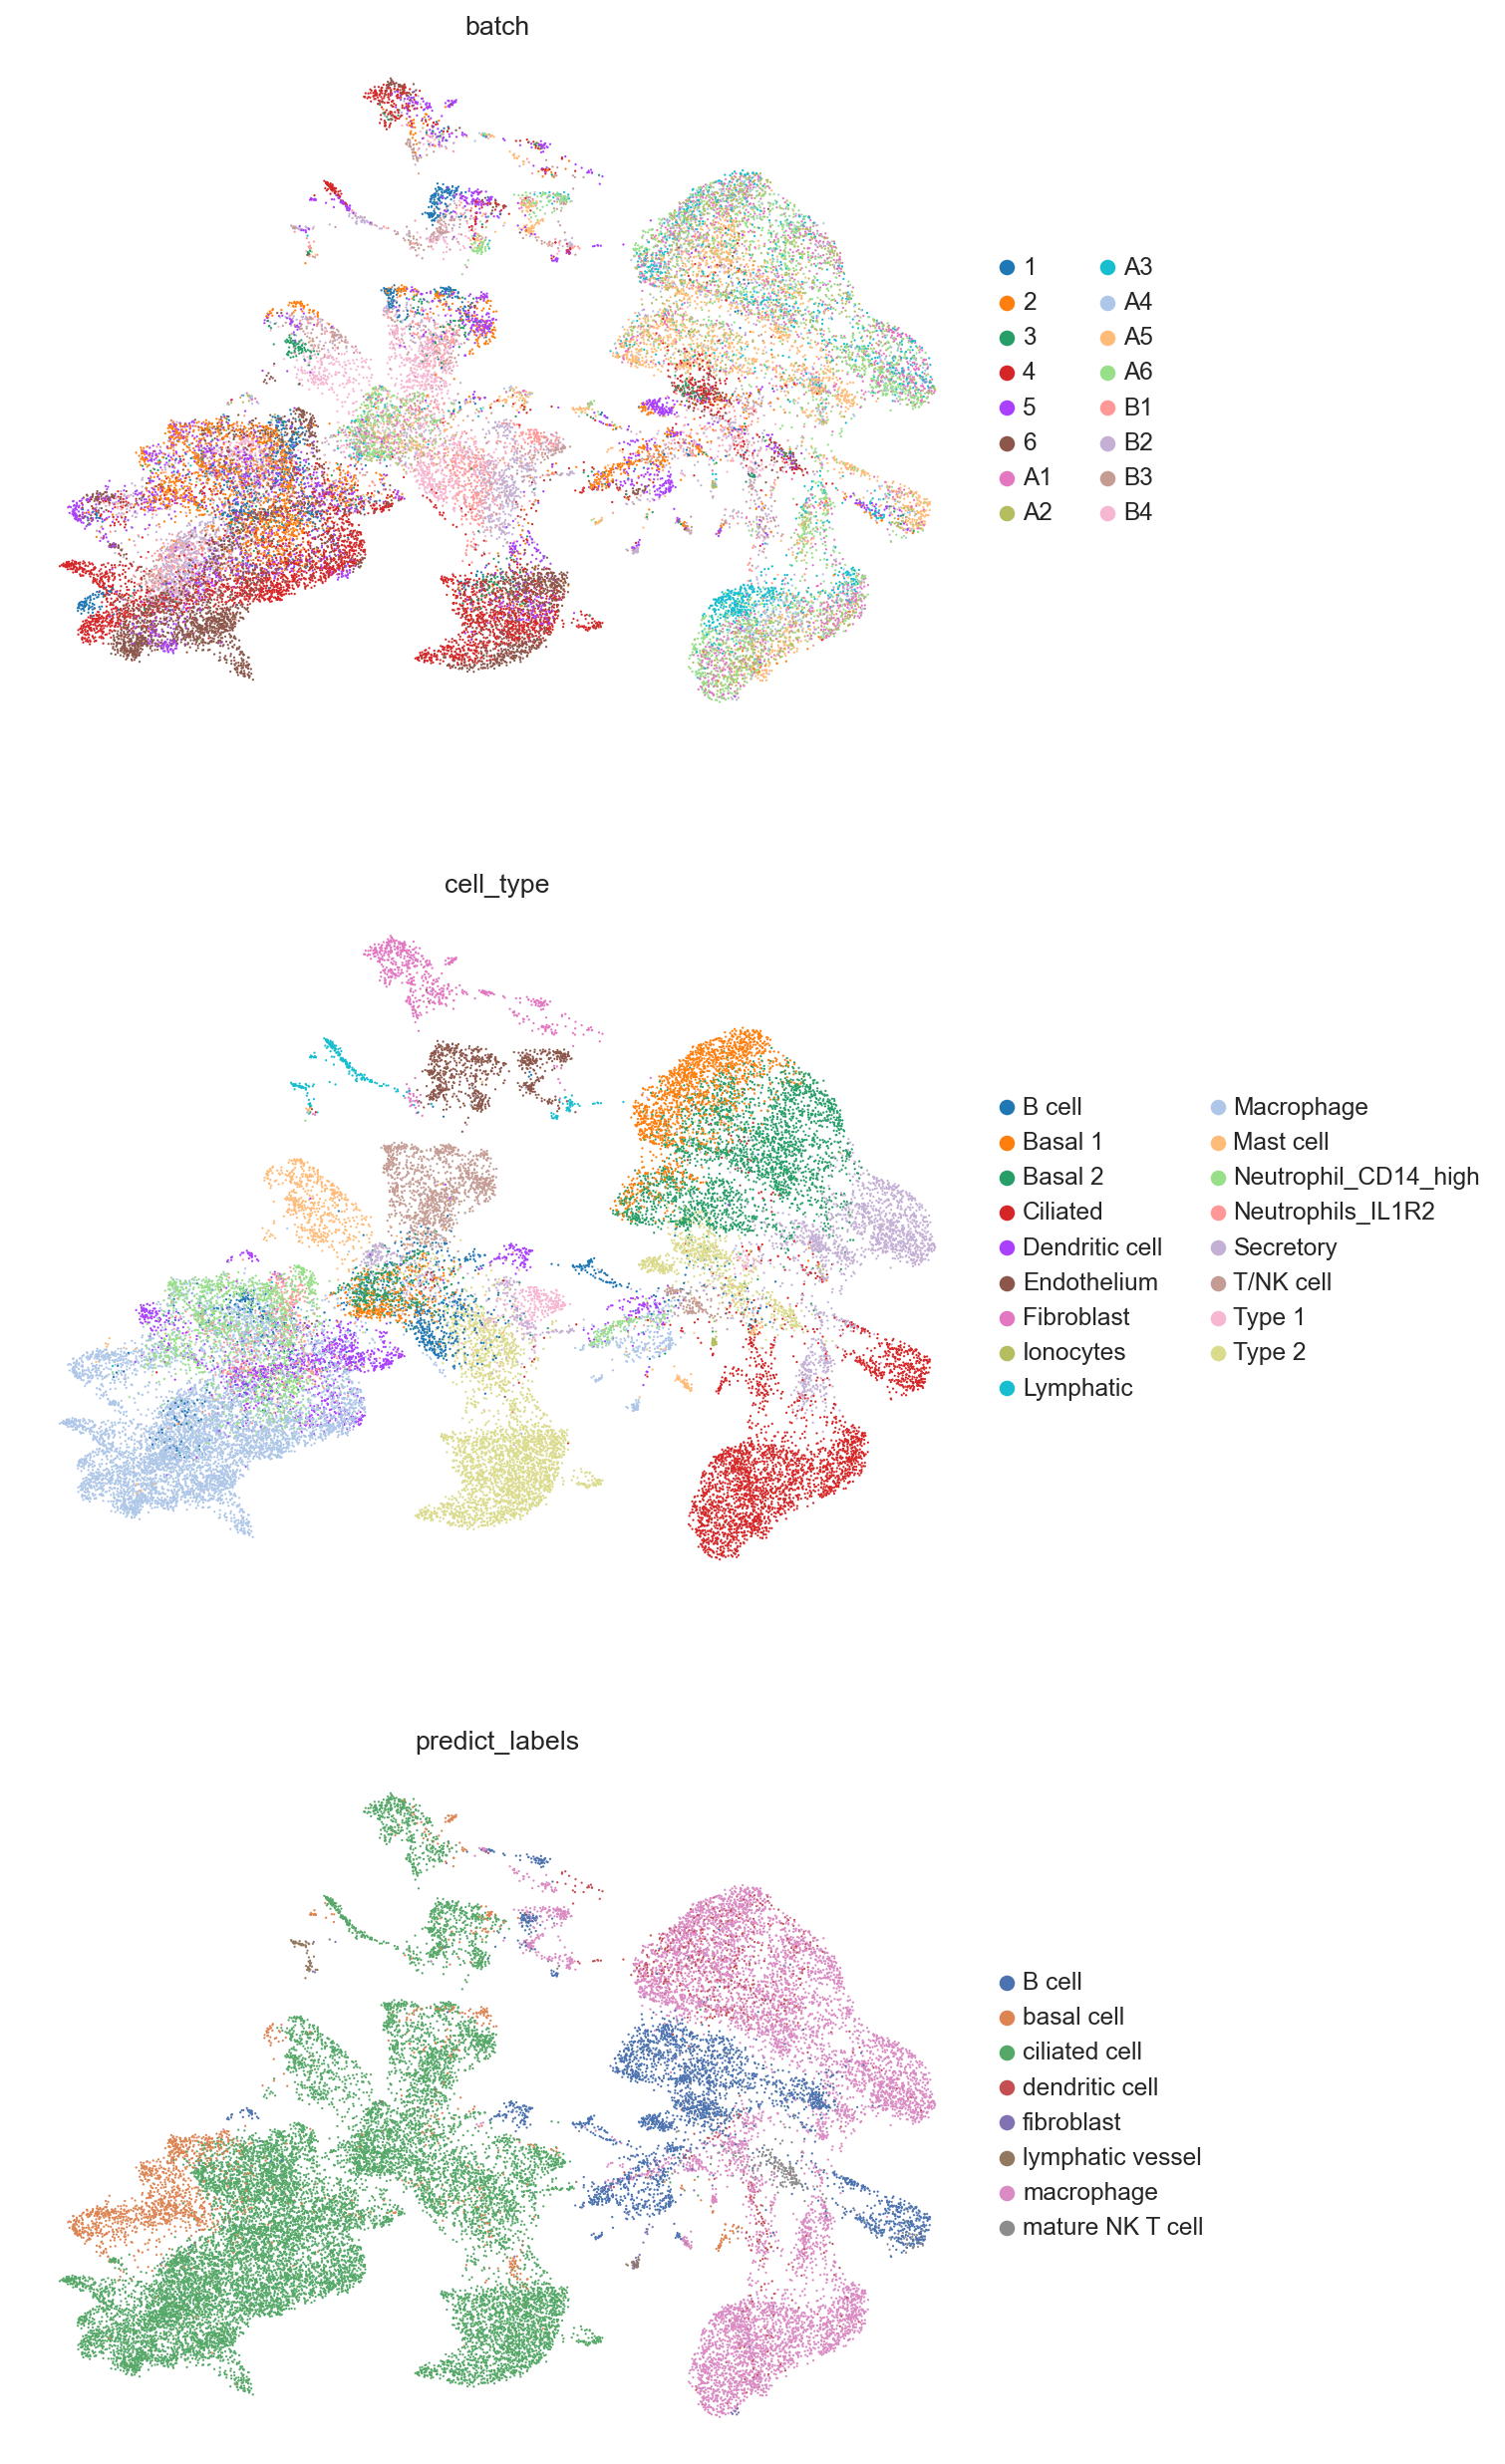

In [44]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', "predict_labels"], wspace=0.4, frameon=False, ncols = 1)

# STACAS

Semi-supervised integration results

In [63]:
pca_embeddings = pd.read_csv('./lung_atlas_stacas_cell_assign.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [64]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

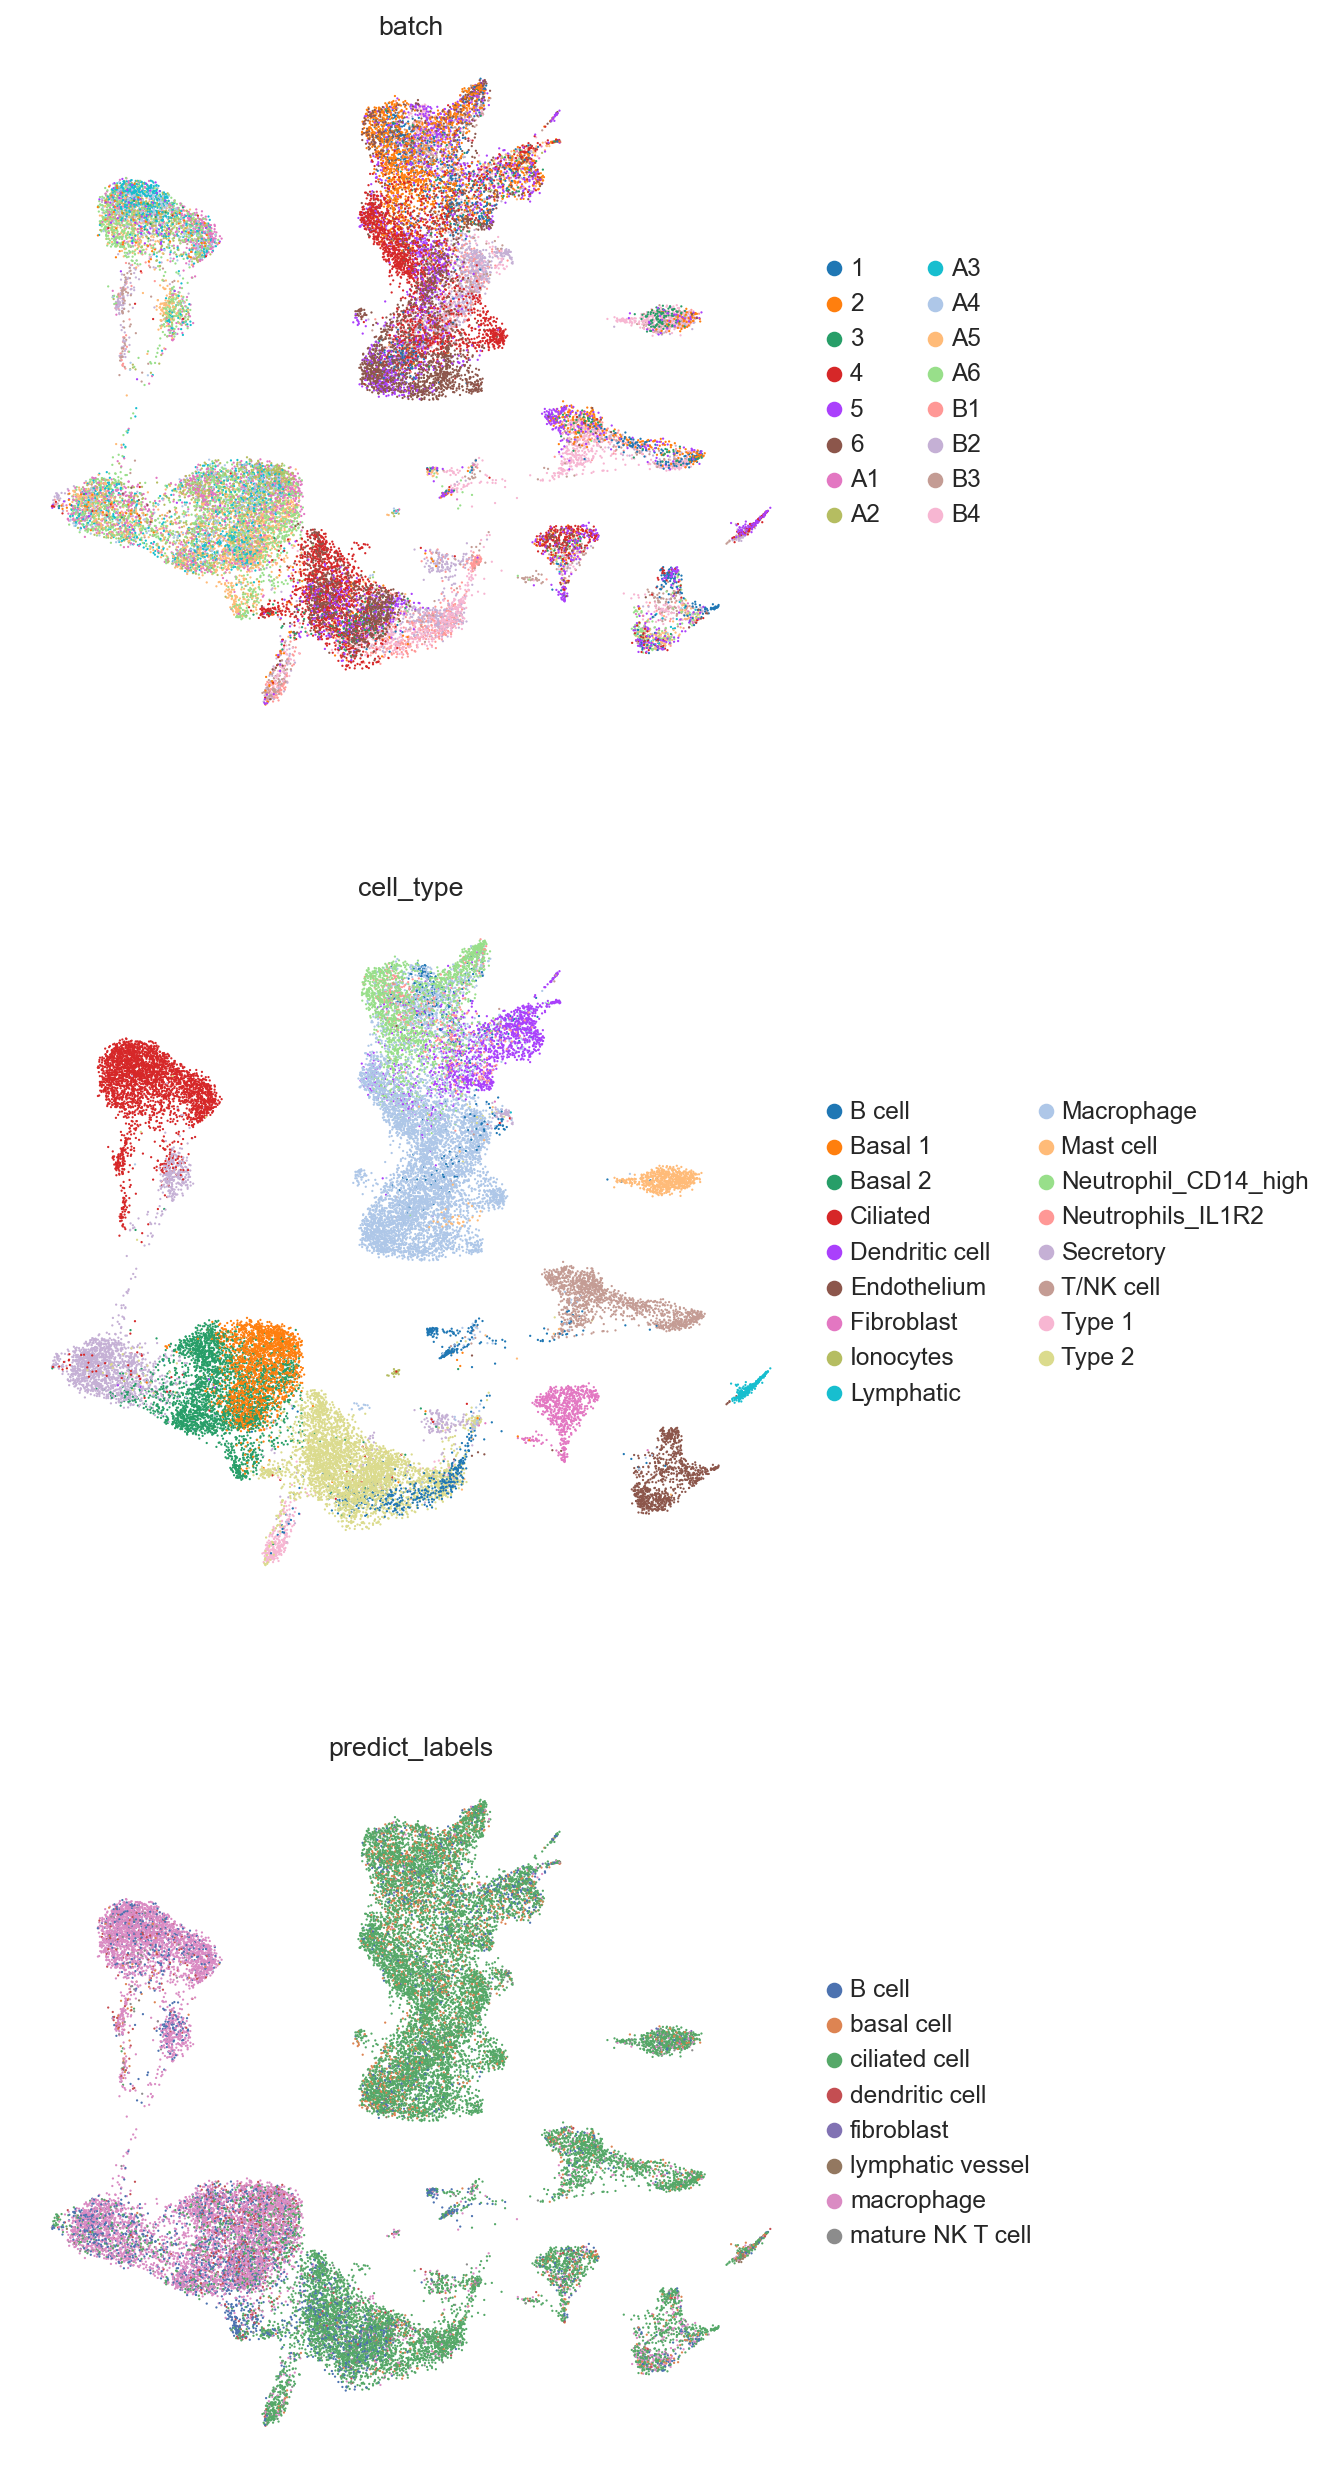

In [65]:
sc.pl.umap(adata, color=["batch", "cell_type", "predict_labels"], frameon=False, ncols=1)

In [66]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("./cell_assign_lung_atlas.csv")


# Metric Evaluation

## read the embeddings

In [67]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("./cell_assign_lung_atlas.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

## Bio-conservation

In [73]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.7362681008085846
resolution: 0.2, nmi: 0.756818546328962
resolution: 0.3, nmi: 0.7655282456445412
resolution: 0.4, nmi: 0.7609174992760158
resolution: 0.5, nmi: 0.7553901246320276
resolution: 0.6, nmi: 0.752918572593107
resolution: 0.7, nmi: 0.7564720340972808
resolution: 0.8, nmi: 0.7556093412202985
resolution: 0.9, nmi: 0.7564293194513527
resolution: 1.0, nmi: 0.739583299712112
resolution: 1.1, nmi: 0.7284720555252323
resolution: 1.2, nmi: 0.7245725100132387
resolution: 1.3, nmi: 0.7111775549498681
resolution: 1.4, nmi: 0.7026925843250592
resolution: 1.5, nmi: 0.692360578298726
resolution: 1.6, nmi: 0.6865315208934857
resolution: 1.7, nmi: 0.6829576596213441
resolution: 1.8, nmi: 0.6756385995898911
resolution: 1.9, nmi: 0.68314679359097
resolution: 2.0, nmi: 0.6712443870047702
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.7655282456445412


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scANVI


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [74]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.6028478541241999
resolution: 0.2, nmi: 0.6048700654829948
resolution: 0.3, nmi: 0.6258542221421967
resolution: 0.4, nmi: 0.6298109453862709
resolution: 0.5, nmi: 0.6381604921167339
resolution: 0.6, nmi: 0.6408570728695856
resolution: 0.7, nmi: 0.6388182553394833
resolution: 0.8, nmi: 0.6346951519383037
resolution: 0.9, nmi: 0.6377565204332557
resolution: 1.0, nmi: 0.6341869487412428
resolution: 1.1, nmi: 0.6350908236537897
resolution: 1.2, nmi: 0.6313230759546722
resolution: 1.3, nmi: 0.6329894719596285
resolution: 1.4, nmi: 0.6328164055341103
resolution: 1.5, nmi: 0.6341053331206737
resolution: 1.6, nmi: 0.6318972449218468
resolution: 1.7, nmi: 0.6279821004813643
resolution: 1.8, nmi: 0.6272138999368313
resolution: 1.9, nmi: 0.6248743727277255
resolution: 2.0, nmi: 0.6206877480164049
optimised clustering against cell_type
optimal cluster resolution: 0.6
optimal score: 0.6408570728695856


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_scgen


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [75]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, silhouette_=True, graph_conn_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.7366019384109287
resolution: 0.2, nmi: 0.7626698836964935
resolution: 0.3, nmi: 0.7687005208743062
resolution: 0.4, nmi: 0.7514715927338107
resolution: 0.5, nmi: 0.7458908433459386
resolution: 0.6, nmi: 0.7367365628908557
resolution: 0.7, nmi: 0.7314210251686044
resolution: 0.8, nmi: 0.7264858426557366
resolution: 0.9, nmi: 0.7258039050541217
resolution: 1.0, nmi: 0.720521969919701
resolution: 1.1, nmi: 0.7124032337639123
resolution: 1.2, nmi: 0.7112817946413493
resolution: 1.3, nmi: 0.7008740186183662
resolution: 1.4, nmi: 0.6837390709001043
resolution: 1.5, nmi: 0.6830554764610257
resolution: 1.6, nmi: 0.6812959998756253
resolution: 1.7, nmi: 0.6827035090700267
resolution: 1.8, nmi: 0.6740854289122276
resolution: 1.9, nmi: 0.6747235581100923
resolution: 2.0, nmi: 0.6717940211352401
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.7687005208743062


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on rep X_stacas


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Isolated labels ASW...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/anaconda3/lib/python3.12/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/opt/ana

In [76]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df

scANVI     scGEN    STACAS
NMI_cluster/label          0.761959  0.642587  0.759914
ARI_cluster/label          0.675927  0.401148  0.646778
ASW_label                  0.571301  0.552624  0.583448
ASW_label/batch            0.901628  0.908053  0.854823
PCR_batch                       NaN       NaN       NaN
cell_cycle_conservation         NaN       NaN       NaN
isolated_label_F1          0.864078  0.672340  0.853081
isolated_label_silhouette  0.633629  0.573033  0.666894
graph_conn                 0.975231  0.957243  0.965300
kBET                            NaN       NaN       NaN
iLISI                           NaN       NaN       NaN
cLISI                           NaN       NaN       NaN
hvg_overlap                     NaN       NaN       NaN
trajectory                      NaN       NaN       NaN